In [59]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

In [60]:
import json

# Define a function to load data from a file
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Load the data from the three files
test_data_path = 'test_bio_labels.json'
train_data_path = 'train_bio_labels.json'
val_data_path = 'val_bio_labels.json'

test_data = load_data(test_data_path)
train_data = load_data(train_data_path)
val_data = load_data(val_data_path)
# Adjusting approach to properly display the data structure and a sample

# Function to safely extract samples from data which might be a dictionary or list
def get_sample(data):
    if isinstance(data, dict):
        # If the data is a dictionary, return a part of it
        return {k: data[k] for k in list(data)[:2]}
    elif isinstance(data, list):
        # If the data is a list, return the first two elements
        return data[:2]
    else:
        return "Unsupported data type"

# Get samples from each dataset
test_data_sample = get_sample(test_data)
train_data_sample = get_sample(train_data)
val_data_sample = get_sample(val_data)

{
    "test_data_sample": test_data_sample,
    "train_data_sample": train_data_sample,
    "val_data_sample": val_data_sample,
}

{'test_data_sample': {'03f3901e95ed493b866bd7807f623bc0': {'text': "True, our Constitution has no 'due process' clause or the VIII Amendment; but, in this branch of law, after R.C. Cooper v. Union of India, (1970) 1 SCC 248 and Maneka Gandhi v. Union of India, (1978) 1 SCC 248, the consequence is the same.",
   'labels': ['O',
    'O',
    'B_STATUTE',
    'I_STATUTE',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'O',
    'B_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'B_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'I_PRECEDENT',
    'O',
    'O',
    'O',
    'O',
    'O']},
  'b0311cba3aac4d909eec6e156c059617': {'text': 

In [61]:
import pandas as pd
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import TweetTokenizer
import nltk

# Convert dictionary data to DataFrame
train_df = pd.DataFrame.from_dict(train_data, orient='index').reset_index(drop=True)
test_df = pd.DataFrame.from_dict(test_data, orient='index').reset_index(drop=True)
val_df = pd.DataFrame.from_dict(val_data, orient='index').reset_index(drop=True)

# Display a sample from the train DataFrame to check preprocessing
train_df.head()

,text,labels
0,"Therefore, while interpreting statutory provis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,The petitioner in W.P.No.15821 of 2008 was nev...,"[O, O, O, B_CASE_NUMBER, I_CASE_NUMBER, I_CASE..."
2,"The factum of accident, allegation of rash and...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B_OTHE..."
3,..36.. \n\n W.A.No.655/2012 & others Meaning t...,"[O, O, B_CASE_NUMBER, I_CASE_NUMBER, O, O, O, ..."
4,The law on this issue is well settled and the ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [62]:
#convert the dataframe to csv
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

In [63]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

# Prepare sentences for Word2Vec training
train_sentences = train_df['text'].apply(lambda x: x.split()).tolist()
test_sentences = test_df['text'].apply(lambda x: x.split()).tolist()
val_sentences = val_df['text'].apply(lambda x: x.split()).tolist()

# Combine sentences from all datasets
all_sentences = train_sentences + test_sentences + val_sentences

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=512, window=5, min_count=1, sg=0)

# Save the model
word2vec_model.save('word2vec_model')

#example
examples_sentence = train_sentences[0]

# Get the word vectors for the example sentence
example_vectors = [word2vec_model.wv[word] for word in examples_sentence if word in word2vec_model.wv.key_to_index]

# Now similarly, convert all the sentences in train_df to vectors
train_df['vectors'] = train_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])
val_df['vectors'] = val_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])
test_df['vectors'] = test_df['text'].apply(lambda x: [word2vec_model.wv[word] for word in x.split() if word in word2vec_model.wv.key_to_index])


In [64]:
#print the length of text of first instance in train_df
print(len(train_df['text'][2].split()))
print(len(train_df['vectors'][2]))

18
18


In [65]:
#checking if the length of the vectors is the same as the length of the text for all instances
train_df['len_text'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['len_vectors'] = train_df['vectors'].apply(lambda x: len(x))
train_df['len_text'].equals(train_df['len_vectors'])

#remove the columns
train_df = train_df.drop(columns=['len_text', 'len_vectors'])

In [66]:
# pad the vectors to have the same length
def pad_vectors(vectors, target_length=50):
    # Get the current length of the vectors
    current_length = len(vectors)

    # If the current length is less than the target length, pad the vectors
    if current_length < target_length:
        # Calculate the number of vectors to be added
        num_to_add = target_length - current_length

        # Add the vectors
        vectors += [np.zeros(512) for _ in range(num_to_add)]

    # if the current length is greater than the target length, slice the vectors
    elif current_length > target_length:
        vectors = vectors[:target_length]

    return vectors

# Pad the vectors in the train, test, and val DataFrames
train_df['vectors'] = train_df['vectors'].apply(lambda x: pad_vectors(x, target_length=50))
val_df['vectors'] = val_df['vectors'].apply(lambda x: pad_vectors(x, target_length=50))
test_df['vectors'] = test_df['vectors'].apply(lambda x: pad_vectors(x, target_length=50))

In [67]:
#get all the unique labels
unique_labels = set()
for labels in train_df['labels']:
    unique_labels.update(labels)

In [68]:
print(len(unique_labels))

27


In [69]:
#padding the labels as well
def pad_labels(labels, target_length=50):
    # Get the current length of the labels
    current_length = len(labels)

    # If the current length is less than the target length, pad the labels
    if current_length < target_length:
        # Calculate the number of labels to be added
        num_to_add = target_length - current_length

        # Add the labels
        labels += ['O' for _ in range(num_to_add)]

    # if the current length is greater than the target length, slice the labels
    elif current_length > target_length:
        labels = labels[:target_length]

    return labels

In [70]:
#giving all labels index
labels_to_index = {label: index for index, label in enumerate(unique_labels)}
print(labels_to_index)

{'B_GPE': 0, 'B_ORG': 1, 'I_PROVISION': 2, 'B_PRECEDENT': 3, 'I_OTHER_PERSON': 4, 'O': 5, 'I_PETITIONER': 6, 'B_WITNESS': 7, 'I_DATE': 8, 'I_PRECEDENT': 9, 'B_DATE': 10, 'I_COURT': 11, 'B_OTHER_PERSON': 12, 'B_PROVISION': 13, 'B_PETITIONER': 14, 'I_GPE': 15, 'B_RESPONDENT': 16, 'B_CASE_NUMBER': 17, 'I_CASE_NUMBER': 18, 'I_ORG': 19, 'I_WITNESS': 20, 'I_RESPONDENT': 21, 'I_STATUTE': 22, 'I_JUDGE': 23, 'B_COURT': 24, 'B_STATUTE': 25, 'B_JUDGE': 26}


In [71]:
# Function to convert labels to indices
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]


In [72]:
# Padding the labels using the provided function
def pad_all_labels(label_sequences, target_length=50):
    return [pad_labels(labels, target_length) for labels in label_sequences]

# Applying the padding function to train, validation, and test label sequences
train_labels_padded = pad_all_labels(train_df['labels'], 50)
val_labels_padded = pad_all_labels(val_df['labels'], 50)
test_labels_padded = pad_all_labels(test_df['labels'], 50)

# Convert label sequences to indices with padding applied
train_labels_indices_padded = labels_to_indices(train_labels_padded, labels_to_index)
val_labels_indices_padded = labels_to_indices(val_labels_padded, labels_to_index)
test_labels_indices_padded = labels_to_indices(test_labels_padded, labels_to_index)

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [74]:
# Example usage
train_labels_indices = labels_to_indices(train_df['labels'], labels_to_index)
val_labels_indices = labels_to_indices(val_df['labels'], labels_to_index)

In [75]:
num_classes = len(labels_to_index)

In [76]:
# Model parameters
input_dim = 512  # Size of the word vectors
hidden_dim = 256  # RNN hidden state size
output_dim = num_classes  # Number of output classes
num_layers = 1  # Number of RNN layers

model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)
loss_function = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters())

In [77]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset

# Updated create_dataset function to handle padded labels
def create_dataset(vectors, labels_indices):
    vectors_tensor = torch.tensor(vectors, dtype=torch.float)
    labels_tensor = torch.tensor(labels_indices, dtype=torch.long)
    dataset = TensorDataset(vectors_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=32, shuffle=True)

# Creating DataLoaders for the training and validation sets
train_loader = create_dataset(train_df['vectors'].tolist(), train_labels_indices_padded)
val_loader = create_dataset(val_df['vectors'].tolist(), val_labels_indices_padded)

# Tracking variables
training_losses = []
validation_losses = []
training_f1_scores = []
validation_f1_scores = []

epochs = 10
for epoch in range(epochs):
    model.train()
    train_losses = []
    val_losses = []
    train_preds, train_true = [], []
    val_preds, val_true = [], []

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 2)
        train_preds.extend(predicted.view(-1).numpy())
        train_true.extend(labels.view(-1).numpy())

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
            val_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 2)
            val_preds.extend(predicted.view(-1).numpy())
            val_true.extend(labels.view(-1).numpy())

    # Calculate F1 scores
    train_f1 = f1_score(train_true, train_preds, average='macro')
    val_f1 = f1_score(val_true, val_preds, average='macro')

    # Store metrics
    training_losses.append(np.mean(train_losses))
    validation_losses.append(np.mean(val_losses))
    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    print(f'Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training F1: {training_f1_scores[-1]}, Validation F1: {validation_f1_scores[-1]}')

Epoch 1, Training Loss: 0.5792150774524232, Validation Loss: 0.4417029716247736, Training F1: 0.08990738517899398, Validation F1: 0.15447898697300655
Epoch 2, Training Loss: 0.3824016837295422, Validation Loss: 0.3580095532328583, Training F1: 0.1975843977965866, Validation F1: 0.22382501312199748
Epoch 3, Training Loss: 0.3374666913358633, Validation Loss: 0.32584492723609126, Training F1: 0.2625093337550297, Validation F1: 0.27539955622413
Epoch 4, Training Loss: 0.318432151224495, Validation Loss: 0.30171498933503793, Training F1: 0.29535198242409383, Validation F1: 0.3043823690493049
Epoch 5, Training Loss: 0.291679603624935, Validation Loss: 0.281095145746719, Training F1: 0.3370910701329175, Validation F1: 0.3378407311668046
Epoch 6, Training Loss: 0.2797325201147844, Validation Loss: 0.2884723606497742, Training F1: 0.3549435051732969, Validation F1: 0.343803397273399
Epoch 7, Training Loss: 0.2715126160870899, Validation Loss: 0.2852557772813841, Training F1: 0.3680723918030872

Text(0, 0.5, 'Loss')

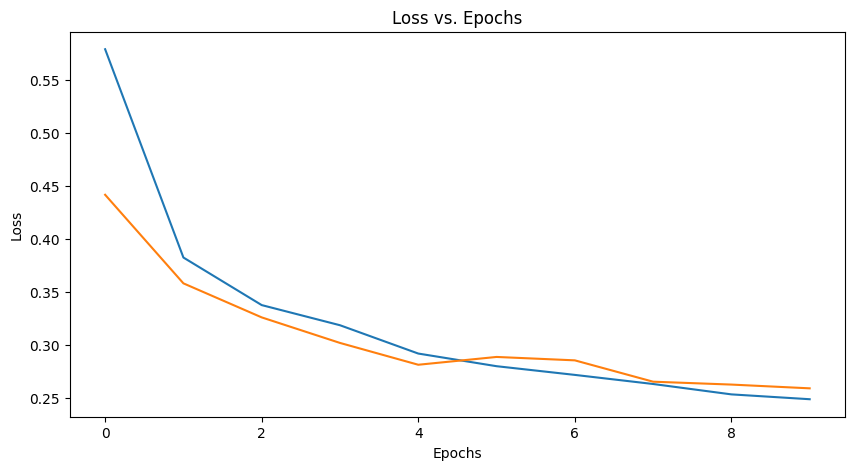

In [78]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')